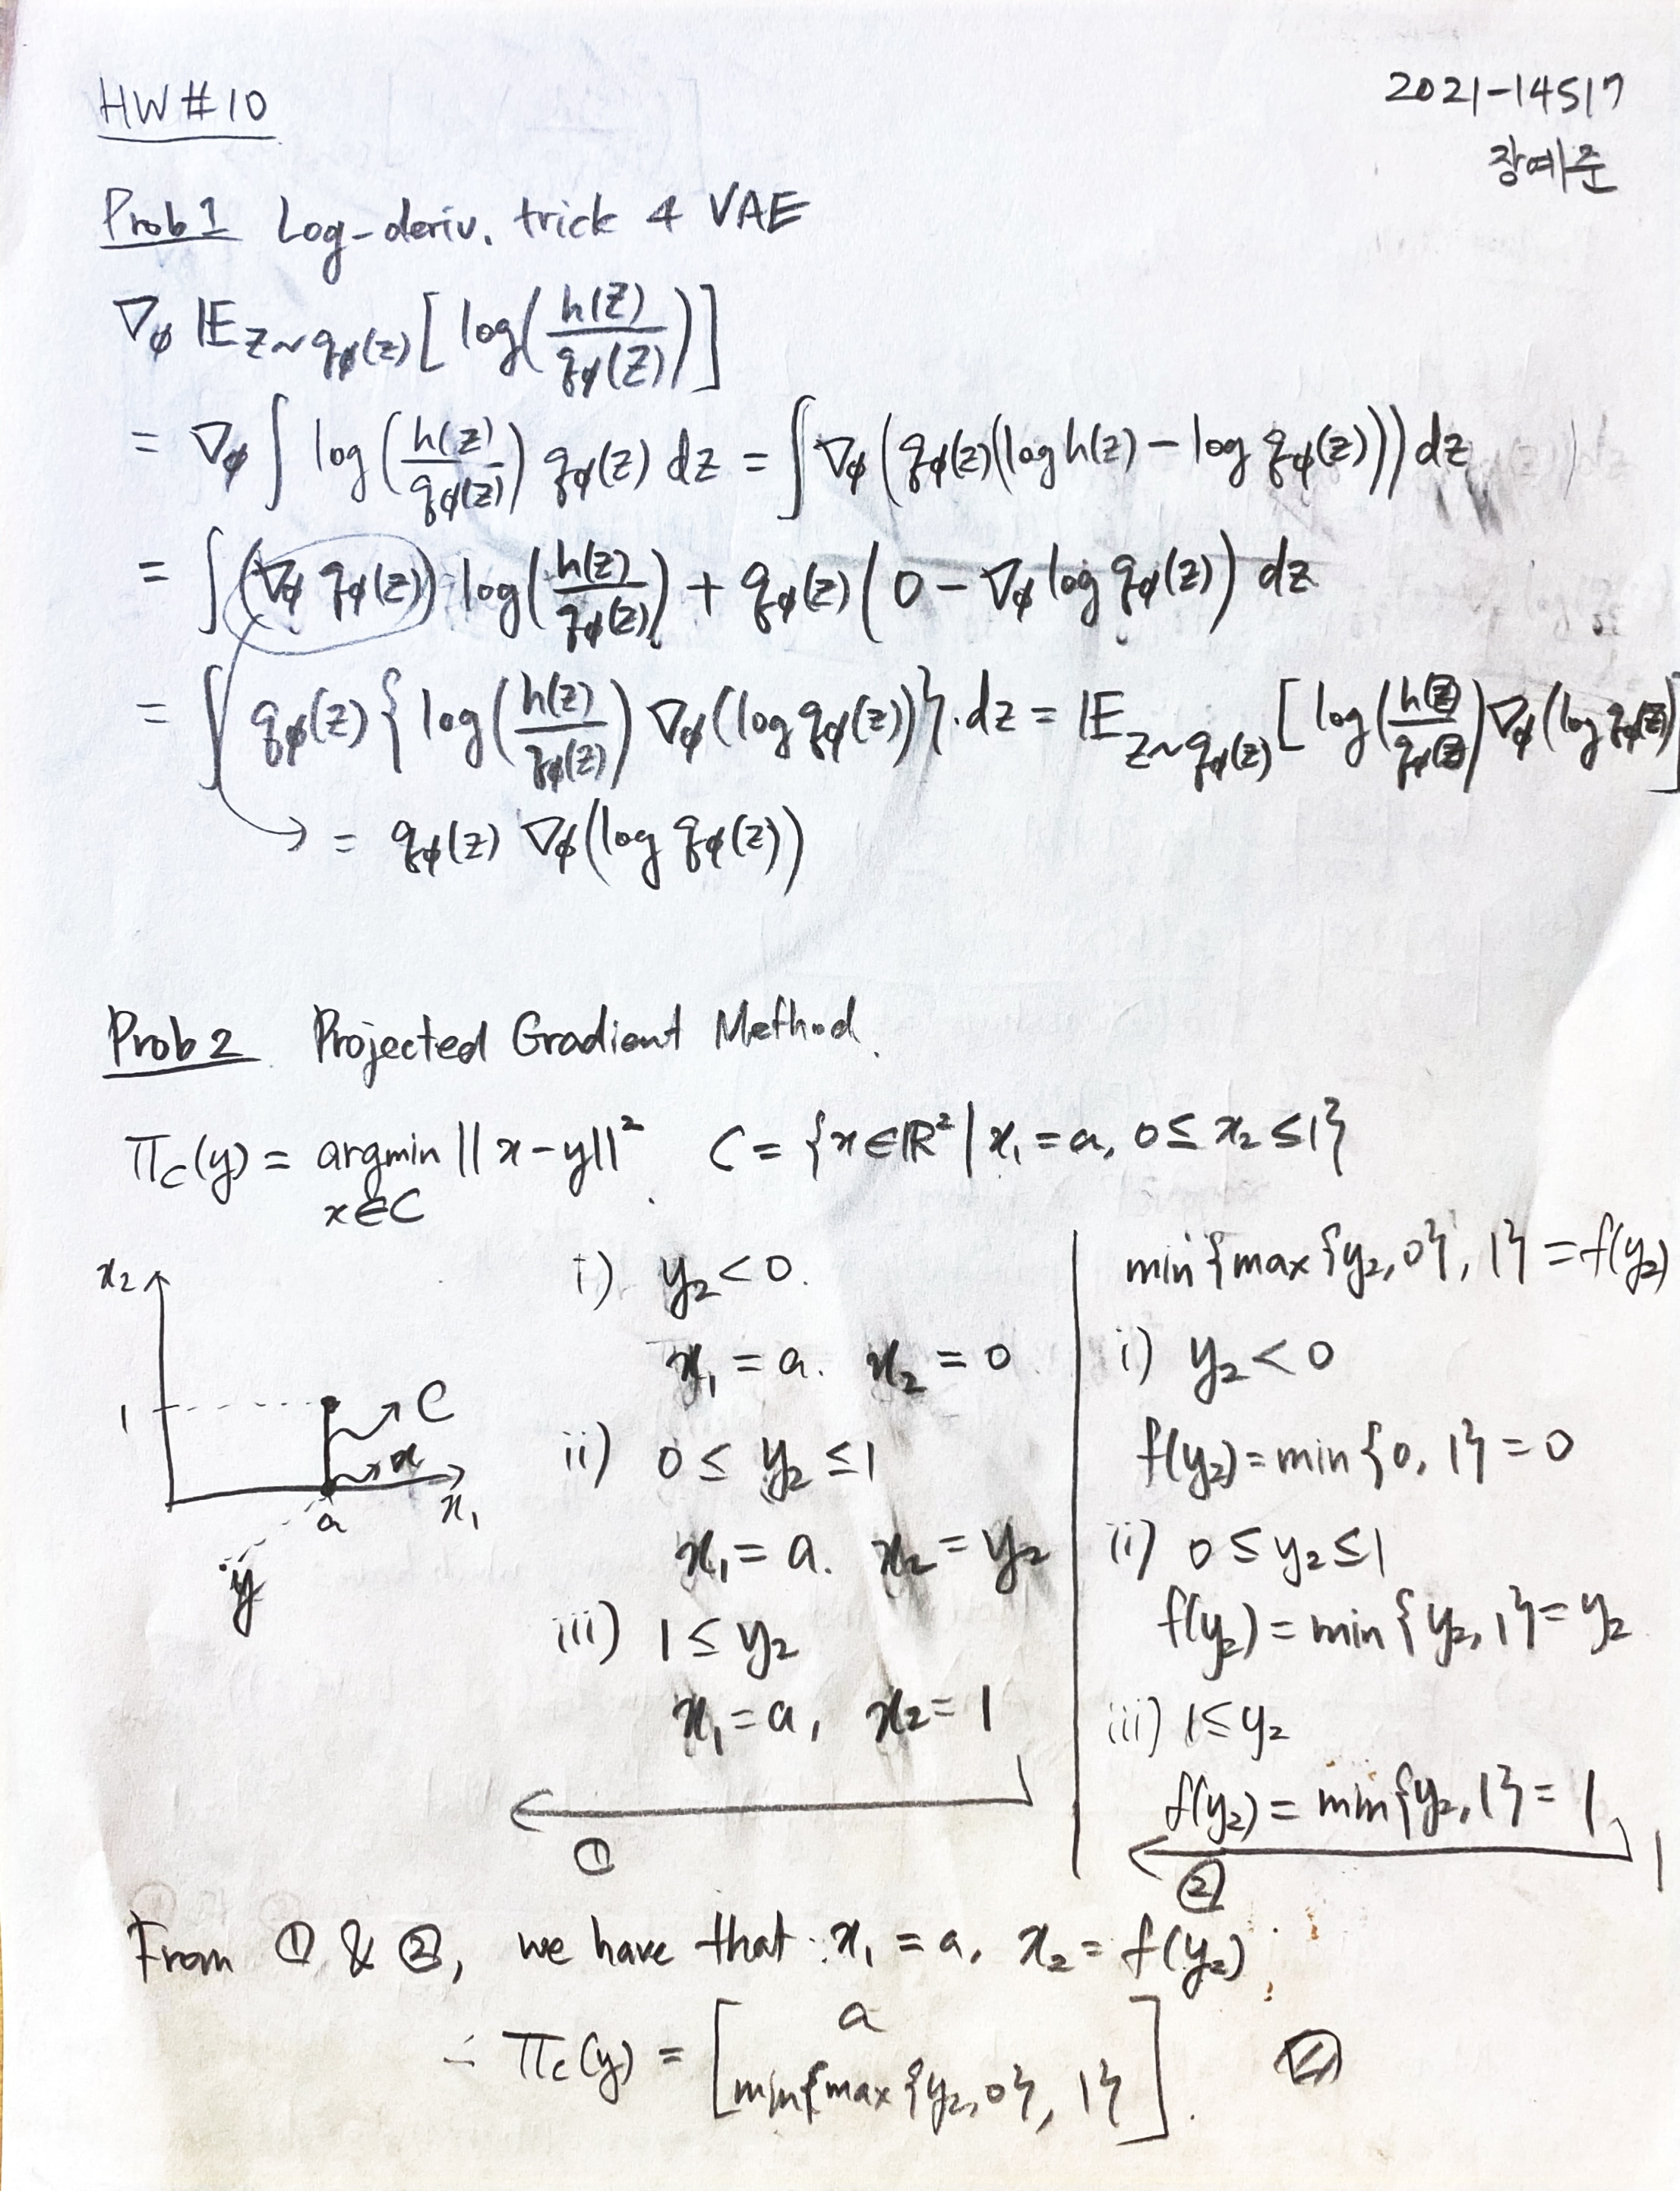

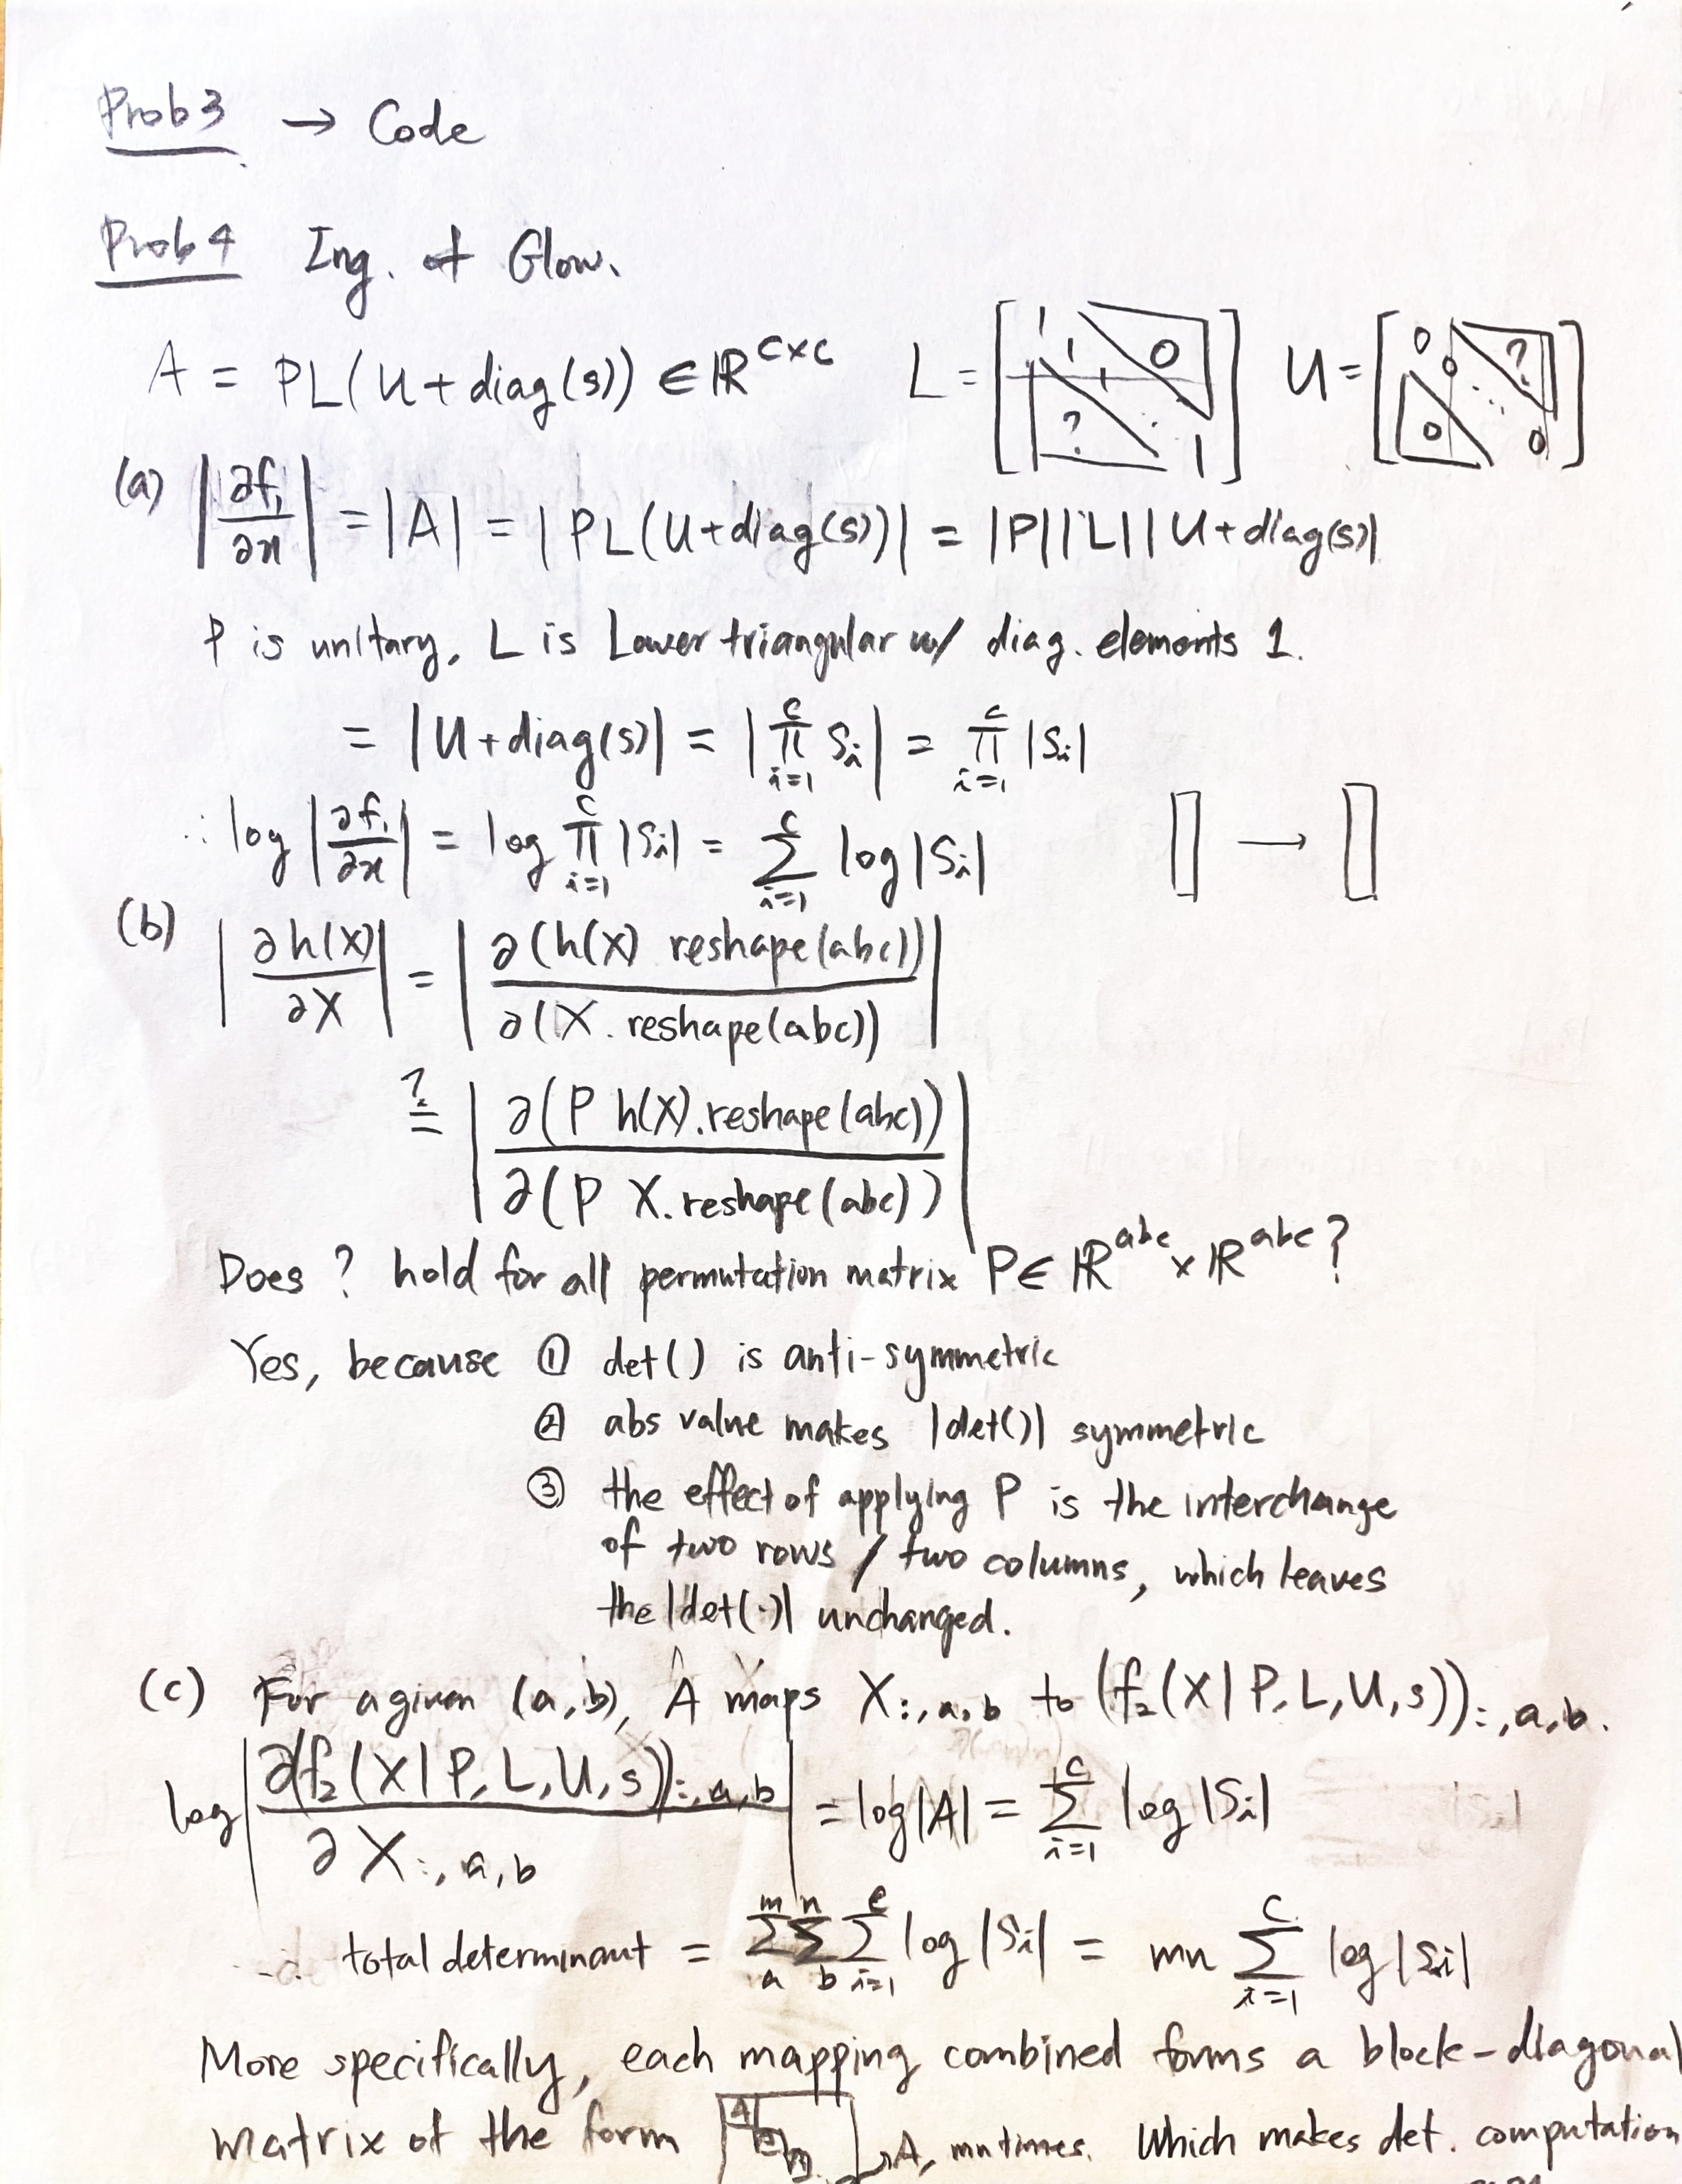

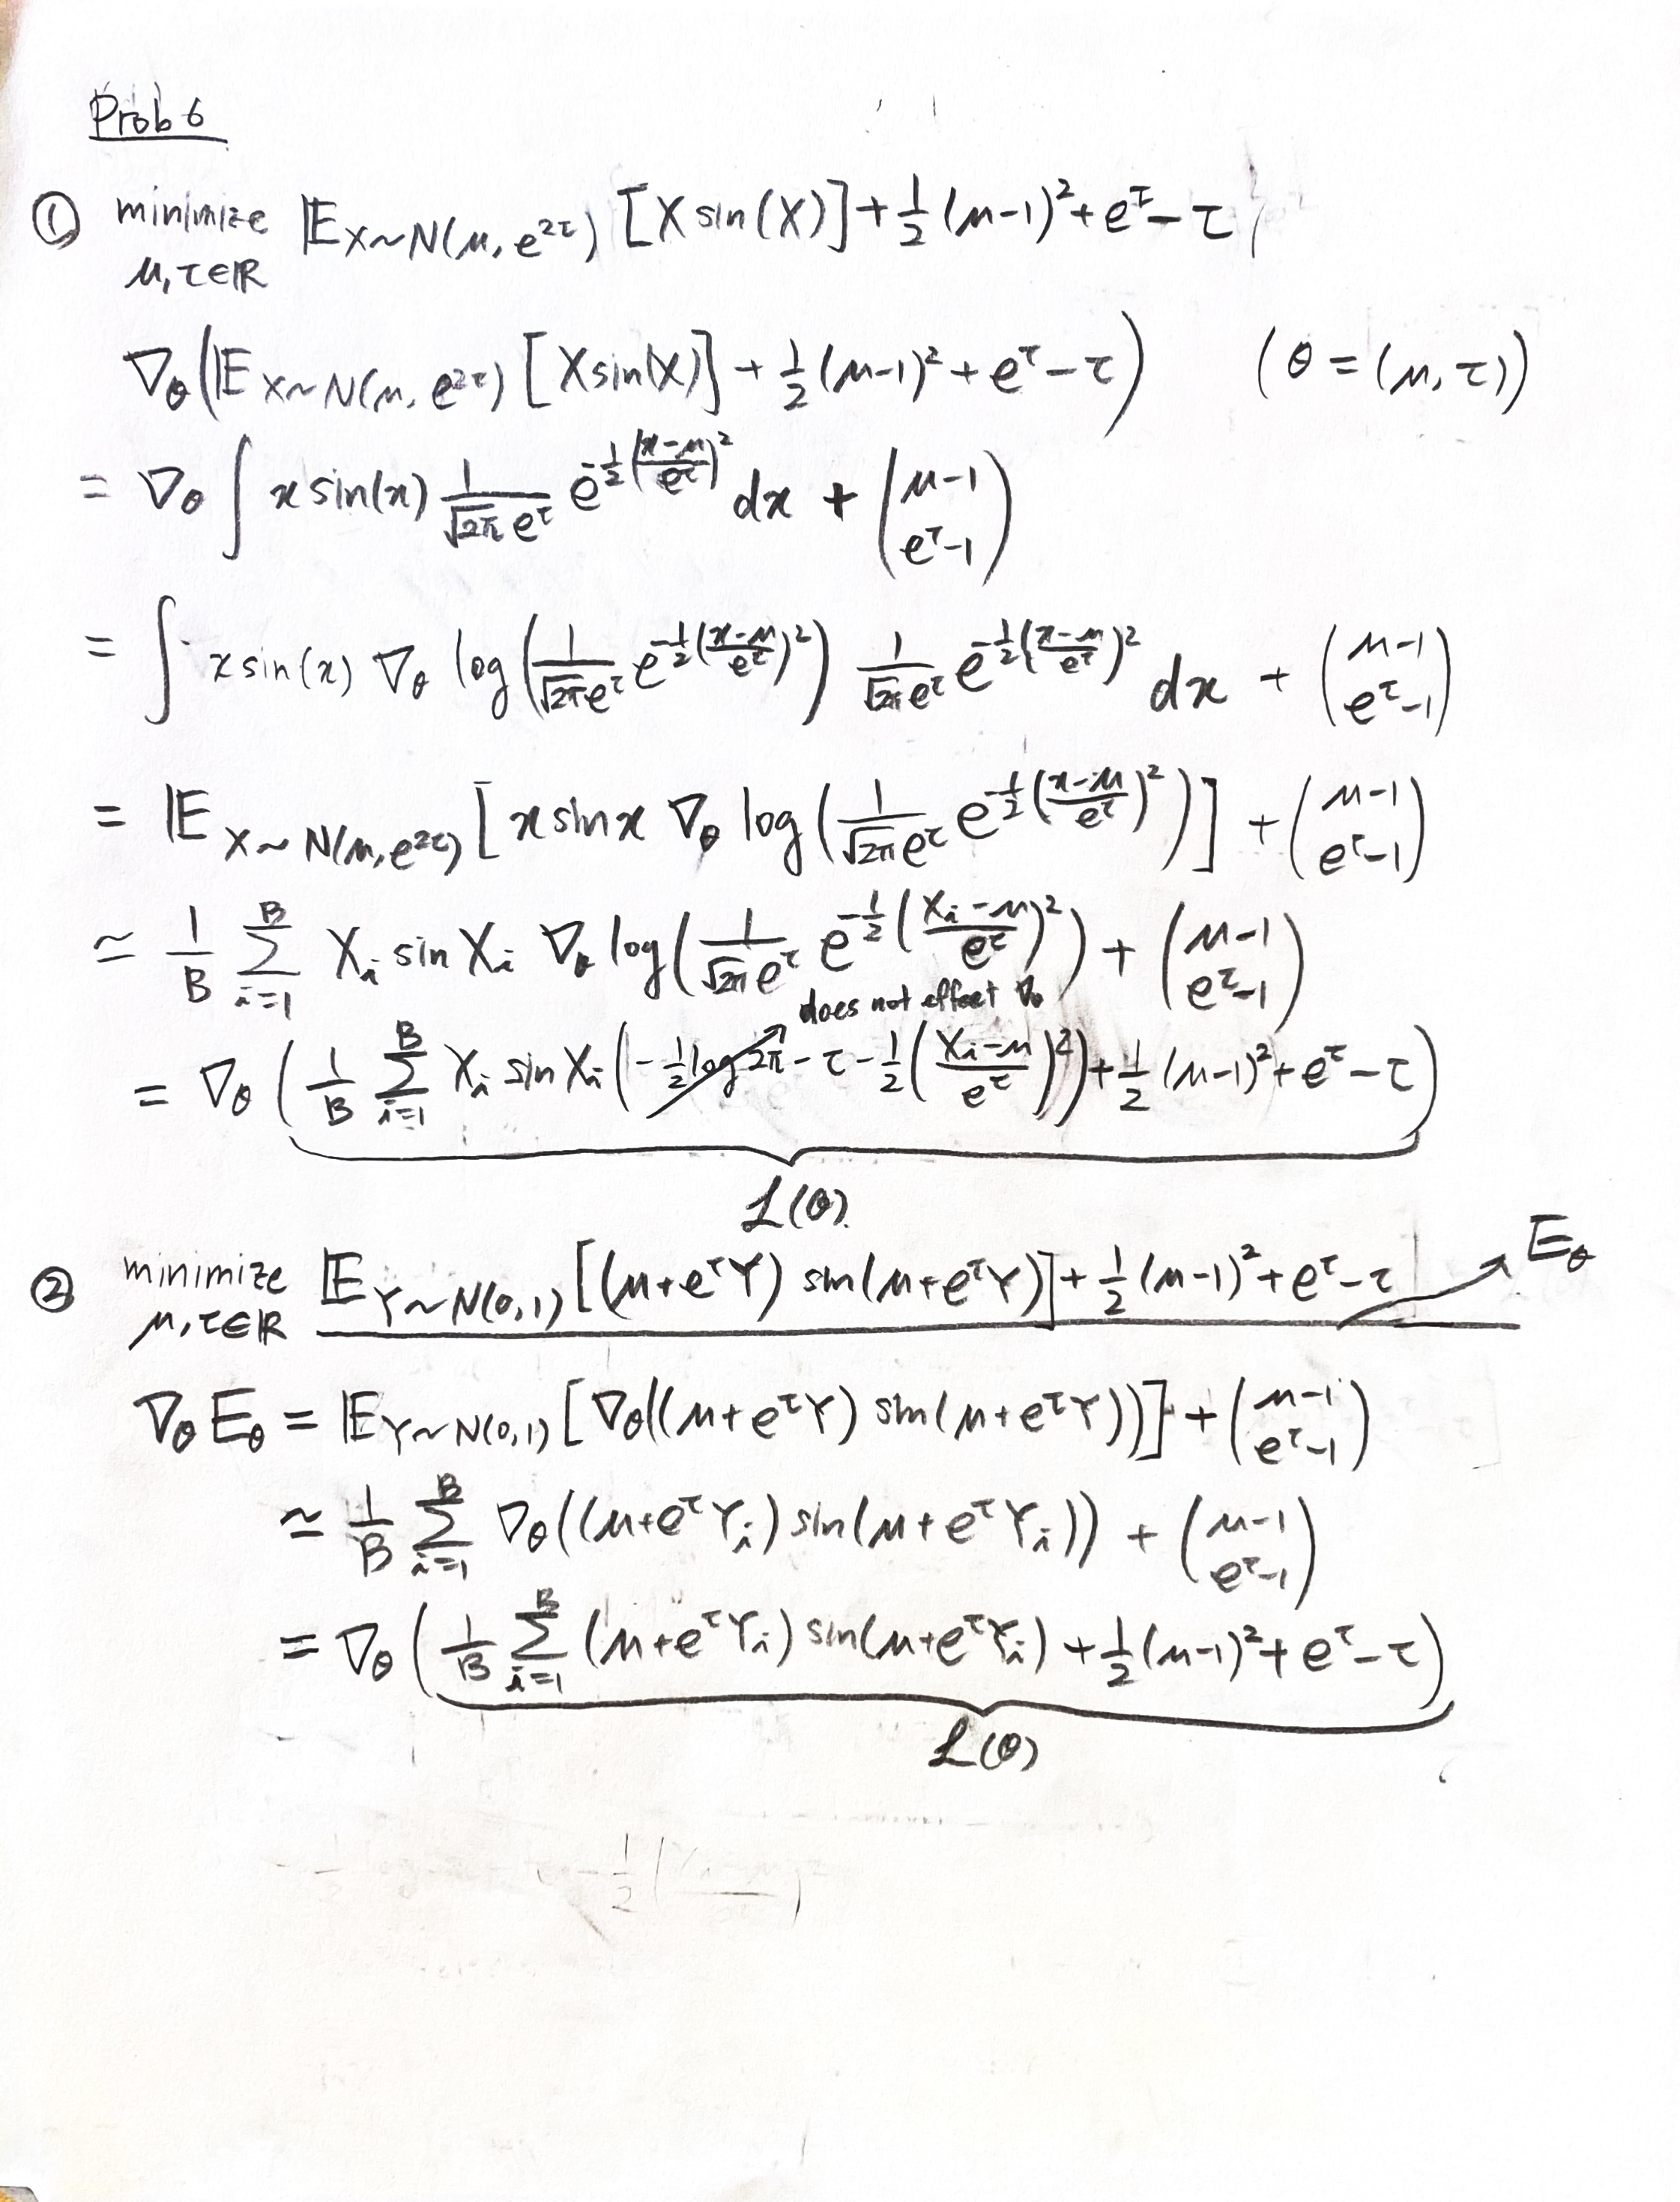

# Problem 3

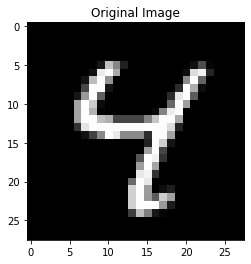

<Figure size 432x288 with 0 Axes>

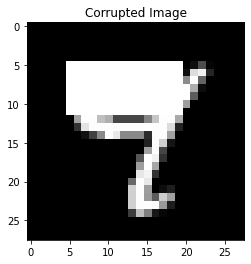

torch.Size([1, 1, 28, 28])


<Figure size 432x288 with 0 Axes>

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cpu")

############################################
# STEP 1: Define dataset and preprocessing #
############################################


class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)
    
####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        # print(x.size())
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J
    
##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)


# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load('nice.pt',map_location=torch.device('cpu')))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = itr.next()
    
plt.figure(figsize = (4,4))
plt.title('Original Image')
plt.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
plt.show()
plt.savefig('plt1.png')


# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
plt.figure(figsize = (4,4))
plt.title('Corrupted Image')
plt.imshow(make_grid(image.squeeze()).permute(1,2,0))
plt.show()
plt.savefig('plt2.png')

lr = 1e-3
X = image.clone().requires_grad_(True)
print(X.size())
optimizer = optim.SGD([X], lr=lr)

for i in range(300):
    optimizer.zero_grad()
    loss = -model(X.reshape((1, 784)))
    X_temp = X.clone()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        torch.clamp(X[mask.logical_not()], min=0, max=1)
        X[mask] = X_temp[mask]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


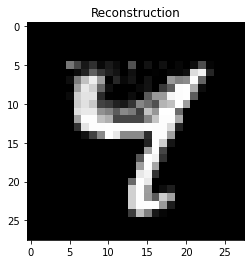

<Figure size 432x288 with 0 Axes>

In [32]:
recon = X.clone()

# Plot reconstruction
plt.figure(figsize = (4,4))
plt.title('Reconstruction')
plt.imshow(make_grid(recon.squeeze().detach()).permute(1,2,0))
plt.show()
plt.savefig('plt3.png')


# Problem 5

In [44]:
import random

N = 3000
n = 600
p = 18/37
q = 0.55
balance = 100
random.seed(1)

p_hats = []
for i in range(N):
    cnt = 0
    for j in range(n):
        balance -= 1
        dice = random.random()
        if dice < p:
            balance += 2
        if balance <= 0 or balance >= 200:
            cnt += 1
            break
    p_hat = cnt/n
    p_hats.append(p_hat)
print(p_hats)


[0.0, 0.0, 0.0, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666668, 0.0016666666666666

# Problem 6

[0.1234, 0.12399378, 0.12423192, 0.1242353, 0.126035, 0.12612632, 0.12622133, 0.12580568, 0.12463328, 0.12426018, 0.1253139, 0.12562954, 0.12518542, 0.12580241, 0.12544599, 0.12478319, 0.12528929, 0.12618607, 0.125456, 0.124366224, 0.12131082, 0.12054337, 0.11924418, 0.11907506, 0.118941635, 0.11934696, 0.11974645, 0.11917021, 0.11986673, 0.119280815, 0.11893239, 0.11884978, 0.11864447, 0.119395085, 0.11945192, 0.120069794, 0.11985331, 0.118667945, 0.118360505, 0.11911077, 0.12008921, 0.122341245, 0.124468386, 0.14087577, 0.14053312, 0.14029342, 0.13957995, 0.13942698, 0.13973199, 0.14043419, 0.14152096, 0.14146927, 0.14051236, 0.14101927, 0.14130631, 0.14118361, 0.1407837, 0.14017136, 0.14026709, 0.13841628, 0.13968475, 0.13980427, 0.1333719, 0.17841212, 0.17856358, 0.17870258, 0.17887495, 0.17903753, 0.17921948, 0.17935978, 0.17954764, 0.17973249, 0.17986009, 0.18000552, 0.1801537, 0.18030512, 0.18043399, 0.18055855, 0.18074721, 0.18087275, 0.18104178, 0.181178, 0.18133536, 0.1814978

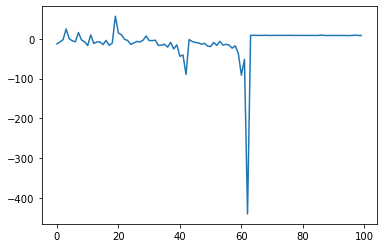

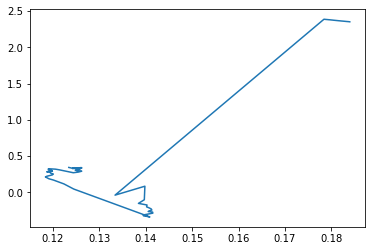

In [38]:
import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import math

mu = 0.1234
tau = 0.345
B = 10

theta = torch.tensor([mu, tau], requires_grad=True)
optimizer = optim.SGD([theta], lr=0.0001)

losses = []
thetas = []
for i in range(100):
    optimizer.zero_grad()
    X = torch.normal(mu, math.exp(tau), (B,))
    # if i==0:
    #     print(X)
    loss = 1/B * torch.sum(X*torch.sin(X)*(-theta[0]-1/2*((X-theta[0])/theta[1])**2)) + 1/2*(theta[0]-1)**2 + torch.exp(theta[1]) - theta[1]
    losses.append(loss.item())
    thetas.append(np.copy(theta.detach().numpy()))
    loss.backward()
    optimizer.step()

mus = [theta[0] for theta in thetas]
taus = [theta[1] for theta in thetas]
print(mus)
plt.figure(1)
plt.plot(losses)
plt.figure(2)
plt.plot(mus, taus)

[0.1234, 0.12347483, 0.12359257, 0.12363558, 0.12367066, 0.12378883, 0.12388214, 0.123919584, 0.123973034, 0.12399833, 0.124063455, 0.12417014, 0.12429955, 0.12437805, 0.12450445, 0.12456147, 0.12471677, 0.12491701, 0.124988794, 0.12498861, 0.12508869, 0.12513807, 0.12519282, 0.12521052, 0.12530269, 0.12535484, 0.12541318, 0.1254837, 0.12555553, 0.12569715, 0.12582277, 0.12590042, 0.12597312, 0.12601718, 0.12614109, 0.12624367, 0.1262683, 0.12636095, 0.12642784, 0.12649868, 0.12657708, 0.12663798, 0.1267325, 0.12681717, 0.12691908, 0.1269681, 0.12707575, 0.1271461, 0.1272488, 0.12733138, 0.1274764, 0.12752317, 0.12758203, 0.12768398, 0.12772451, 0.12784532, 0.12798691, 0.1280759, 0.12815739, 0.12817378, 0.12824978, 0.1283007, 0.12840083, 0.1284249, 0.12848625, 0.1285735, 0.12865388, 0.12875065, 0.12886097, 0.12890914, 0.12896946, 0.12900177, 0.12903689, 0.12911226, 0.12920988, 0.12931865, 0.12936983, 0.1294851, 0.12957768, 0.12970725, 0.12985796, 0.1299097, 0.13004433, 0.13014598, 0.13

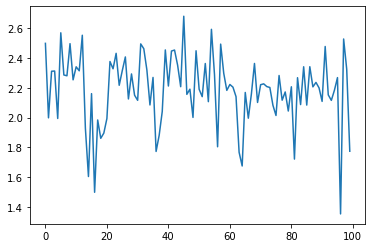

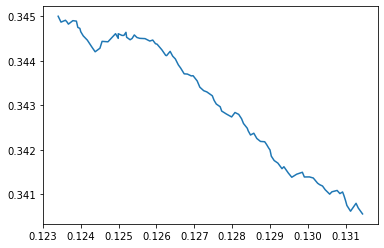

In [39]:
mu = 0.1234
tau = 0.345
B = 10

theta = torch.tensor([mu, tau], requires_grad=True)
optimizer = optim.SGD([theta], lr=0.0001)

losses = []
thetas = []
for i in range(100):
    optimizer.zero_grad()
    Y = torch.normal(0, 1, (B,))
    # if i==0:
    #     print(X)
    loss = 1/B * torch.sum((theta[0]+torch.exp(theta[1])*Y)*torch.sin((theta[0]+torch.exp(theta[1])*Y))+1/2*(theta[0]-1)**2 + torch.exp(theta[1]) - theta[1])
    losses.append(loss.item())
    thetas.append(np.copy(theta.detach().numpy()))
    loss.backward()
    optimizer.step()

mus = [theta[0] for theta in thetas]
taus = [theta[1] for theta in thetas]
print(mus)
plt.figure(1)
plt.plot(losses)
plt.figure(2)
plt.plot(mus, taus)